In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./data/train/train.csv')

In [3]:
train.tail()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0
52559,1094,23,30,0,0,2.1,67.70,-4,0.0


In [4]:
submission = pd.read_csv('./data/sample_submission.csv')

In [5]:
submission.tail()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7775,80.csv_Day8_23h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


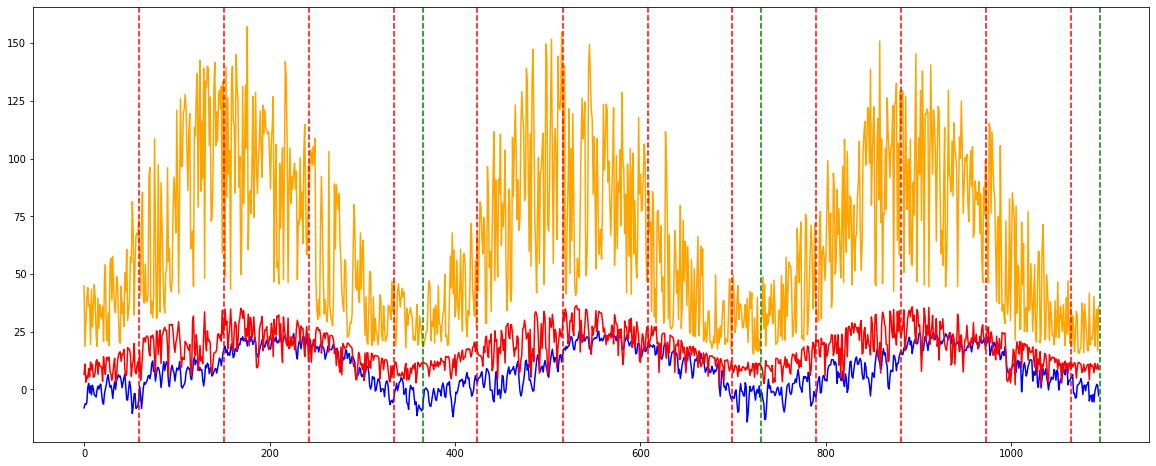

In [7]:
# 계절 나누기

t = train.groupby('Day').mean()
month = [31+28, 31+30+31, 30+31+31, 30+31+30, 31]          # [겨울, 봄, 여름, 가을, 겨울]

plt.figure(figsize=(20,8))
plt.plot(t['T'], color='blue')
plt.plot(t['DHI'], color='orange')
plt.plot(t['TARGET'], color='red')
m=0
for i in range(3):
    for j in range(5):
        m += month[j]
        if j==4:
            plt.axvline(x=m, color='g', linestyle='--')
        else:
            plt.axvline(x=m, color='r', linestyle='--')
plt.show()

# Preprocessing (Train)

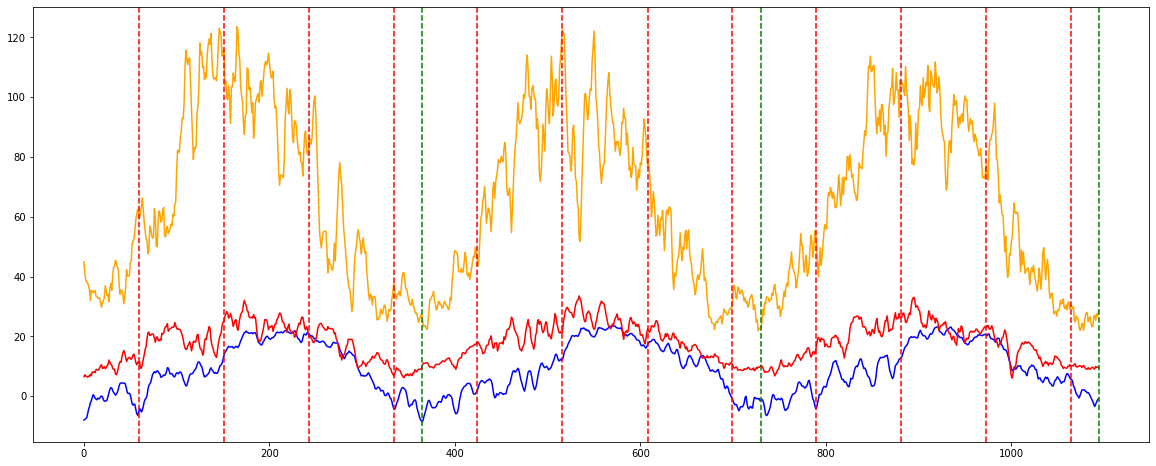

In [8]:
temp = train.copy()

# 30분 단위로 표현

temp['Minute'] = temp['Minute']/60
temp['Time'] = temp['Hour'] + temp['Minute']


# GHI = DHI + DNI

temp['GHI'] = temp['DHI'] + temp['DNI']


# 계절 변수 생성

month = [31+28, 31+30+31, 30+31+31, 30+31+30, 31]          # [겨울, 봄_가을, 여름, 봄_가을, 겨울]

season = []
for i in range(3):
    year = ['Winter']*month[0]*48 + ['Spring_Fall']*month[1]*48 + ['Summer']*month[2]*48 + ['Spring_Fall']*month[3]*48 + ['Winter']*month[4]*48
    season += year
    
temp['Season'] = season


# 계절 판단 기준

df_T = temp.groupby('Day').mean()
df_DHI = temp.groupby('Day').mean()
df_Target = temp.groupby('Day').mean()

for lag in [1,2,3,4,5,6]:
    df_T['T_lag_%s'%lag] = df_T['T'].shift(lag).fillna(method='bfill')
    df_DHI['DHI_lag_%s'%lag] = df_DHI['DHI'].shift(lag).fillna(method='bfill')
    df_Target['Target_lag_%s'%lag] = df_Target['TARGET'].shift(lag).fillna(method='bfill')
    
season = []
for i in range(3):
    year = ['Winter']*month[0] + ['Spring']*month[1] + ['Summer']*month[2] + ['Fall']*month[3] + ['Winter']*month[4]
    season += year
df_T['Season'] = season
df_DHI['Season'] = season
df_Target['Season'] = season

df_T = df_T[['Season', 'T', 'T_lag_1', 'T_lag_2', 'T_lag_3', 'T_lag_4', 'T_lag_5', 'T_lag_6']]
df_DHI = df_DHI[['Season', 'DHI', 'DHI_lag_1', 'DHI_lag_2', 'DHI_lag_3', 'DHI_lag_4', 'DHI_lag_5', 'DHI_lag_6']]
df_Target = df_Target[['Season', 'TARGET', 'Target_lag_1', 'Target_lag_2', 'Target_lag_3', 'Target_lag_4', 'Target_lag_5', 'Target_lag_6']]
df_T['T_mean'] = df_T.mean(axis=1)
df_DHI['DHI_mean'] = df_DHI.mean(axis=1)
df_Target['Target_mean'] = df_Target.mean(axis=1)

df_season = pd.DataFrame({'Season' : df_T['Season'], 'T_mean' : df_T['T_mean'], 
                          'DHI_mean' : df_DHI['DHI_mean'], 'Target_mean' : df_Target['Target_mean']}).reset_index(drop=True)

plt.figure(figsize=(20,8))
plt.plot(df_season['T_mean'], color='blue')
plt.plot(df_season['DHI_mean'], color='orange')
plt.plot(df_season['Target_mean'], color='red')
m=0
for i in range(3):
    for j in range(5):
        m += month[j]
        if j==4:
            plt.axvline(x=m, color='g', linestyle='--')
        else:
            plt.axvline(x=m, color='r', linestyle='--')
plt.show()

In [9]:
df_season.groupby('Season').agg([min,max])        # 기준 : 겨울 ~0  봄가을 0~15  여름 15~

T_mean              DHI_mean             Target_mean           
              min        max        min         max         min        max
Season                                                                    
Fall    -3.083333  20.812500  22.238095  100.336310    6.049196  25.271062
Spring  -5.500000  14.068452  39.991071  123.000000    9.319954  27.902417
Summer  12.232143  23.586310  51.761905  123.541667   17.032536  33.523739
Winter  -8.648810   5.714286  21.877976   62.529762    6.166902  17.618068

In [10]:
# 자기회귀

lags = [1,2,3,4]
cols = ['TARGET', 'DHI', 'DNI', 'GHI', 'WS', 'RH', 'T']
lag_cols = []

for col in cols:
    for lag in lags:
        temp[col + '_lag_%s'%lag] = temp[col].shift(lag*48)                   # 전날의 변수들을 독립변수로 사용
        temp['Target1'] = temp['TARGET']                                      # 예측할값1 => 오늘 발전량
        temp['Target2'] = temp['TARGET'].shift(-48)                           # 예측할값2 => 내일 발전량
        lag_cols.append(col + '_lag_%s'%lag)                                  # 사용할 칼럼 이름 저장


# 계절-시간 별 평균/사분위수

time = temp['Time'].unique()
season = ['Spring_Fall', 'Summer', 'Winter']
dv_t=[]

for s in season :
    tst_season=[]
    tst_mean=[]
    tst_q1=[]
    tst_q2=[]
    tst_q3=[]
    
    for t in time :
        tst = temp.loc[(temp['Season']==s) & (temp['Time']==t)]['TARGET']
        tst_season.append(s)
        tst_mean.append(tst.mean())
        tst_q1.append(tst.quantile(.25))
        tst_q2.append(tst.quantile(.5))
        tst_q3.append(tst.quantile(.75))
        
    dv_t.append(pd.DataFrame({'tst_mean' : tst_mean, 'tst_q1' : tst_q1, 'tst_q2' : tst_q2, 'tst_q3' : tst_q3}))

spring_fall_t = dv_t[0]
summer_t = dv_t[1]
winter_t = dv_t[2]

dv_r=[]

for s in season :
    rst_season=[]
    rst_mean=[]
    rst_q1=[]
    rst_q2=[]
    rst_q3=[]
    
    for t in time :
        rst = temp.loc[(temp['Season']==s) & (temp['Time']==t)]['GHI']
        rst_season.append(s)
        rst_mean.append(rst.mean())
        rst_q1.append(rst.quantile(.25))
        rst_q2.append(rst.quantile(.5))
        rst_q3.append(rst.quantile(.75))
        
    dv_r.append(pd.DataFrame({'rst_mean' : rst_mean, 'rst_q1' : rst_q1, 'rst_q2' : rst_q2, 'rst_q3' : rst_q3}))

spring_fall_r = dv_r[0]
summer_r = dv_r[1]
winter_r = dv_r[2]

month = [31+28, 31+30+31, 30+31+31, 30+31+30, 31]          # [겨울, 봄, 여름, 가을, 겨울]
season_t = [winter_t, spring_fall_t, summer_t, spring_fall_t, winter_t]
season_r = [winter_r, spring_fall_r, summer_r, spring_fall_r, winter_r]
df_dv_t = pd.DataFrame()
df_dv_r = pd.DataFrame()

for i in range(3):
    for s, m in zip(season_t, month):
        for j in range(m):
            df_dv_t = pd.concat([df_dv_t, s])
            
df_dv_t.reset_index(drop=True, inplace=True)
dv_t_cols = list(df_dv_t.columns)
temp = pd.concat([temp, df_dv_t], axis=1)

for i in range(3):
    for s, m in zip(season_r, month):
        for j in range(m):
            df_dv_r = pd.concat([df_dv_r, s])
            
df_dv_r.reset_index(drop=True, inplace=True)
dv_r_cols = list(df_dv_r.columns)
temp = pd.concat([temp, df_dv_r], axis=1)


# 7일간 발전량/일사량 평균

target_4 = temp[['TARGET_lag_1', 'TARGET_lag_2', 'TARGET_lag_3', 'TARGET_lag_4']]
temp['Target_4'] = target_4.mean(axis=1)

GHI_4 = temp[['GHI_lag_1', 'GHI_lag_2', 'GHI_lag_3', 'GHI_lag_4']]
temp['GHI_4'] = GHI_4.mean(axis=1)


df_train = temp[['Target1', 'Target2'] + ['Time'] + lag_cols + dv_t_cols + dv_r_cols + ['Target_4', 'GHI_4']].dropna()
df_train.reset_index(drop=True, inplace=True)
df_train.iloc[:48]

,Target1,Target2,Time,TARGET_lag_1,TARGET_lag_2,TARGET_lag_3,TARGET_lag_4,DHI_lag_1,DHI_lag_2,DHI_lag_3,...,tst_mean,tst_q1,tst_q2,tst_q3,rst_mean,rst_q1,rst_q2,rst_q3,Target_4,GHI_4
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
1,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
2,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
3,0.000000,0.000000,1.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
4,0.000000,0.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
5,0.000000,0.000000,2.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
6,0.000000,0.000000,3.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
7,0.000000,0.000000,3.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
8,0.000000,0.000000,4.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00
9,0.000000,0.000000,4.5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.00


In [11]:
df_train.columns

Index(['Target1', 'Target2', 'Time', 'TARGET_lag_1', 'TARGET_lag_2',
       'TARGET_lag_3', 'TARGET_lag_4', 'DHI_lag_1', 'DHI_lag_2', 'DHI_lag_3',
       'DHI_lag_4', 'DNI_lag_1', 'DNI_lag_2', 'DNI_lag_3', 'DNI_lag_4',
       'GHI_lag_1', 'GHI_lag_2', 'GHI_lag_3', 'GHI_lag_4', 'WS_lag_1',
       'WS_lag_2', 'WS_lag_3', 'WS_lag_4', 'RH_lag_1', 'RH_lag_2', 'RH_lag_3',
       'RH_lag_4', 'T_lag_1', 'T_lag_2', 'T_lag_3', 'T_lag_4', 'tst_mean',
       'tst_q1', 'tst_q2', 'tst_q3', 'rst_mean', 'rst_q1', 'rst_q2', 'rst_q3',
       'Target_4', 'GHI_4'],
      dtype='object')

In [12]:
len(df_train.columns)

41

In [13]:
df_train.corr()

,Target1,Target2,Time,TARGET_lag_1,TARGET_lag_2,TARGET_lag_3,TARGET_lag_4,DHI_lag_1,DHI_lag_2,DHI_lag_3,...,tst_mean,tst_q1,tst_q2,tst_q3,rst_mean,rst_q1,rst_q2,rst_q3,Target_4,GHI_4
Target1,1.000000,0.842926,0.003760,0.842907,0.817650,0.806899,0.805247,0.690455,0.703076,0.710208,...,0.880550,0.860270,0.877848,0.876177,0.834559,0.825982,0.833974,0.814885,0.876540,0.800025
Target2,0.842926,1.000000,0.003764,0.817674,0.806986,0.805267,0.805884,0.703101,0.710214,0.714485,...,0.880000,0.859706,0.877389,0.875555,0.834369,0.825591,0.833808,0.814756,0.866660,0.788845
Time,0.003760,0.003764,1.000000,0.003749,0.003752,0.003766,0.003742,0.029861,0.029858,0.029850,...,0.004229,-0.029021,0.002033,0.021101,-0.010084,-0.063280,-0.026946,0.013114,0.004020,-0.009324
TARGET_lag_1,0.842907,0.817674,0.003749,1.000000,0.842860,0.817559,0.806851,0.666691,0.690405,0.703064,...,0.880961,0.860540,0.878361,0.876681,0.834599,0.826113,0.834041,0.814927,0.928653,0.858708
TARGET_lag_2,0.817650,0.806986,0.003752,0.842860,1.000000,0.842697,0.817509,0.689043,0.666657,0.690390,...,0.881734,0.861255,0.879252,0.877528,0.834720,0.826523,0.834186,0.814965,0.938240,0.870157
TARGET_lag_3,0.806899,0.805267,0.003766,0.817559,0.842697,1.000000,0.842624,0.707062,0.689019,0.666581,...,0.882386,0.861884,0.879859,0.878257,0.835100,0.827142,0.834594,0.815259,0.938191,0.870071
TARGET_lag_4,0.805247,0.805884,0.003742,0.806851,0.817509,0.842624,1.000000,0.709528,0.707039,0.689007,...,0.882993,0.862410,0.880467,0.878965,0.835240,0.827469,0.834724,0.815368,0.928574,0.858684
DHI_lag_1,0.690455,0.703101,0.029861,0.666691,0.689043,0.707062,0.709528,1.000000,0.703177,0.674165,...,0.767409,0.725036,0.767385,0.775432,0.717847,0.679681,0.712347,0.714226,0.742522,0.638786
DHI_lag_2,0.703076,0.710214,0.029858,0.690405,0.666657,0.689019,0.707039,0.703177,1.000000,0.703151,...,0.767848,0.725448,0.767848,0.775925,0.718040,0.679977,0.712538,0.714399,0.737379,0.632035
DHI_lag_3,0.710208,0.714485,0.029850,0.703064,0.690390,0.666581,0.689007,0.674165,0.703151,1.000000,...,0.768266,0.725843,0.768489,0.776334,0.718055,0.680050,0.712540,0.714428,0.736287,0.630762


# Preprocessing (Test)

In [14]:
df_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    
    
    # 30분 단위로 표현

    temp['Minute'] = temp['Minute']/60
    temp['Time'] = temp['Hour'] + temp['Minute']
    
    
    # GHI = DHI + DNI

    temp['GHI'] = temp['DHI'] + temp['DNI']

    
    # 계절 구분 기준

    T_mean = temp['T'].mean()


    # 자기회귀

    df_append = temp.iloc[:48, :]
    temp = pd.concat([temp, df_append]).reset_index()

    lags = [1,2,3,4]
    cols = ['TARGET', 'DHI', 'DNI', 'GHI', 'WS', 'RH', 'T']
    lag_cols = []

    for col in cols:
        for lag in lags:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag*48)          # 전날의 변수들을 독립변수로 사용
            lag_cols.append(col + '_lag_%s'%lag)

            
   # 7일간 발전량/일사량 평균

    target_4 = temp[['TARGET_lag_1', 'TARGET_lag_2', 'TARGET_lag_3', 'TARGET_lag_4']]
    temp['Target_4'] = target_4.mean(axis=1)

    GHI_4 = temp[['GHI_lag_1', 'GHI_lag_2', 'GHI_lag_3', 'GHI_lag_4']]
    temp['GHI_4'] = GHI_4.mean(axis=1)
    
    
    # day7만 사용
    
    temp = temp.iloc[-48:, :]
    temp.reset_index(drop=True, inplace=True)
    
    
    # 계절-시간 별 평균/사분위수

    if T_mean < 0:
        temp = pd.concat([temp, winter_t, winter_r], axis=1)

    elif (T_mean >= 0) & (T_mean < 15):
        temp = pd.concat([temp, spring_fall_t, spring_fall_r], axis=1)

    elif T_mean >= 15:
        temp = pd.concat([temp, summer_t, summer_r], axis=1)

    dv_cols = list(winter_t.columns) + list(winter_r.columns)


    temp = temp[['Time'] + lag_cols + dv_cols + ['Target_4', 'GHI_4']].dropna()
    temp.reset_index(drop=True, inplace=True)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 39)

In [15]:
X_test.columns

Index(['Time', 'TARGET_lag_1', 'TARGET_lag_2', 'TARGET_lag_3', 'TARGET_lag_4',
       'DHI_lag_1', 'DHI_lag_2', 'DHI_lag_3', 'DHI_lag_4', 'DNI_lag_1',
       'DNI_lag_2', 'DNI_lag_3', 'DNI_lag_4', 'GHI_lag_1', 'GHI_lag_2',
       'GHI_lag_3', 'GHI_lag_4', 'WS_lag_1', 'WS_lag_2', 'WS_lag_3',
       'WS_lag_4', 'RH_lag_1', 'RH_lag_2', 'RH_lag_3', 'RH_lag_4', 'T_lag_1',
       'T_lag_2', 'T_lag_3', 'T_lag_4', 'tst_mean', 'tst_q1', 'tst_q2',
       'tst_q3', 'rst_mean', 'rst_q1', 'rst_q2', 'rst_q3', 'Target_4',
       'GHI_4'],
      dtype='object')

In [16]:
len(X_test.columns)

39

In [17]:
# train 지정

X_train = df_train.iloc[:, 2:]
y_train_1 = df_train.iloc[:, 0]
y_train_2 = df_train.iloc[:, 1]

In [ ]:
# ! pip install scikit-garden

In [26]:
from skgarden import RandomForestQuantileRegressor

def modeling(X_train, y_train, X_test):

    models=[]
    preds = pd.DataFrame()
    quantiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

    for q in quantiles:
        print('\n',q)
        
        model = RandomForestQuantileRegressor(n_estimators=100, random_state=100)                   
        model.fit(X_train, y_train)
        models.append(model)
        
        pred = pd.Series(model.predict(X_test, q).round(2))
        preds = pd.concat([preds, pred],axis=1)

    preds.columns=quantiles
    
    return models, preds

In [47]:
from sklearn.ensemble.forest import ForestRegressor
from skgarden import DecisionTreeQuantileRegressor

class BaseForestQuantileRegressor(ForestRegressor):
    def fit(self, X, y):
        # apply method requires X to be of dtype np.float32
        X, y = check_X_y(
            X, y, accept_sparse="csc", dtype=np.float32, multi_output=False)
        super(BaseForestQuantileRegressor, self).fit(X, y)

        self.y_train_ = y
        self.y_train_leaves_ = -np.ones((self.n_estimators, len(y)), dtype=np.int32)
        self.y_weights_ = np.zeros_like((self.y_train_leaves_), dtype=np.float32)

        for i, est in enumerate(self.estimators_):
            if self.bootstrap:
                bootstrap_indices = generate_sample_indices(
                    est.random_state, len(y))
            else:
                bootstrap_indices = np.arange(len(y))

            est_weights = np.bincount(bootstrap_indices, minlength=len(y))
            y_train_leaves = est.y_train_leaves_
            for curr_leaf in np.unique(y_train_leaves):
                y_ind = y_train_leaves == curr_leaf
                self.y_weights_[i, y_ind] = (
                    est_weights[y_ind] / np.sum(est_weights[y_ind]))

            self.y_train_leaves_[i, bootstrap_indices] = y_train_leaves[bootstrap_indices]
        return self

    def predict(self, X, quantile=None):
        # apply method requires X to be of dtype np.float32
        X = check_array(X, dtype=np.float32, accept_sparse="csc")
        if quantile is None:
            return super(BaseForestQuantileRegressor, self).predict(X)

        sorter = np.argsort(self.y_train_)
        X_leaves = self.apply(X)
        weights = np.zeros((X.shape[0], len(self.y_train_)))
        quantiles = np.zeros((X.shape[0]))
        for i, x_leaf in enumerate(X_leaves):
            mask = self.y_train_leaves_ != np.expand_dims(x_leaf, 1)
            x_weights = ma.masked_array(self.y_weights_, mask)
            weights = x_weights.sum(axis=0)
            quantiles[i] = weighted_percentile(
                self.y_train_, quantile, weights, sorter)
        return quantiles


class ExtraTreesQuantileRegressor(BaseForestQuantileRegressor):
    def __init__(self,
                 n_estimators=10,
                 criterion='mse',
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0,
                 max_features='auto',
                 max_leaf_nodes=None,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=1,
                 random_state=None,
                 verbose=0,
                 warm_start=False):
        super(ExtraTreesQuantileRegressor, self).__init__(
            base_estimator=DecisionTreeQuantileRegressor(),
            n_estimators=n_estimators,
            estimator_params=("criterion", "max_depth", "min_samples_split",
                              "min_samples_leaf", "min_weight_fraction_leaf",
                              "max_features", "max_leaf_nodes",
                              "random_state"),
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start)

        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes

In [18]:
from skgarden import ExtraTreesQuantileRegressor

def modeling(X_train, y_train, X_test):

    models=[]
    preds = pd.DataFrame()
    quantiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

    for q in quantiles:
        print('\n',q)
        
        model = ExtraTreesQuantileRegressor(n_estimators=100, random_state=100)                   
        model.fit(X_train, y_train)
        models.append(model)
        
        pred = pd.Series(model.predict(X_test, q).round(2))
        preds = pd.concat([preds, pred],axis=1)

    preds.columns=quantiles
    
    return models, preds

# Tensorflow

In [ ]:
git clone https://github.com/yicjia/DeepQuantreg.git
cd DeepQuantreg
pip install .

In [ ]:
model = dq.deep_quantreg(X_train,test_df,layer=2,node=300,n_epoch=50,bsize=64,acfn="sigmoid",opt="Adam",tau=0.5,verbose=0)

from DeepQuantreg import deep_quantreg as dq

def modeling(X_train, y_train, X_test):

    models=[]
    preds = pd.DataFrame()
    quantiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

    for q in quantiles:
        print('\n',q)
        
        model = ExtraTreeQuantileRegressor(random_state=100)                   
        model.fit(X_train, y_train)
        models.append(model)
        
        pred = pd.Series(model.predict(X_test, q).round(2))
        preds = pd.concat([preds, pred],axis=1)

    preds.columns=quantiles
    
    return models, preds

In [19]:
# Target1
models_1, results_1 = modeling(X_train, y_train_1, X_test)
results_1.sort_index()[:48]


 10

 20

 30

 40

 50

 60

 70

 80

 90


,10,20,30,40,50,60,70,80,90
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [20]:
# Target2
models_2, results_2 = modeling(X_train, y_train_2, X_test)
results_2.sort_index()[:48]


 10

 20

 30

 40

 50

 60

 70

 80

 90


,10,20,30,40,50,60,70,80,90
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [21]:
results_1.sort_index().iloc[:48]

,10,20,30,40,50,60,70,80,90
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [22]:
results_2.sort_index()

,10,20,30,40,50,60,70,80,90
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
print(results_1.shape, results_2.shape)

(3888, 9) (3888, 9)


In [24]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [26]:
submission.iloc[48:96]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
48,0.csv_Day8_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49,0.csv_Day8_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50,0.csv_Day8_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
51,0.csv_Day8_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
52,0.csv_Day8_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
53,0.csv_Day8_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
54,0.csv_Day8_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
55,0.csv_Day8_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
56,0.csv_Day8_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57,0.csv_Day8_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [27]:
submission.to_csv('./data/submission_26.csv', index=False)